# Imports and utils

In [1]:
import torch as t
import torch.utils.data
from torch import nn, optim
from torch.autograd import Variable
from torch.nn import functional as F
from torchvision import datasets, transforms
from torchvision.utils import save_image
import numpy as np
from sklearn.utils import shuffle
from IPython import display
from matplotlib import pyplot as plt

train_loader = torch.utils.data.DataLoader(
    datasets.MNIST('../data', train=True, download=False,
                   transform=transforms.ToTensor()),
    batch_size=1, shuffle=True)
test_loader = torch.utils.data.DataLoader(
    datasets.MNIST('../data', train=False, transform=transforms.ToTensor()),
    batch_size=1, shuffle=True)


In [73]:
def variable(array, requires_grad=False, to_float=True, cuda=False):
    """Wrapper for t.autograd.Variable"""
    if isinstance(array, np.ndarray):
        v = t.autograd.Variable(t.from_numpy(array), requires_grad=requires_grad)
    elif isinstance(array, list) or isinstance(array,tuple):
        v = t.autograd.Variable(t.from_numpy(np.array(array)), requires_grad=requires_grad)
    elif isinstance(array, float) or isinstance(array, int):
        v = t.autograd.Variable(t.from_numpy(np.array([array])), requires_grad=requires_grad)
    elif isinstance(array, t.Tensor) or isinstance(array, t.LongTensor) or isinstance(array, t.FloatTensor) or isinstance(array, t.DoubleTensor) :
        v = t.autograd.Variable(array, requires_grad=requires_grad)
    else: raise ValueError
    if cuda:
        v = v.cuda()
    if to_float:
        return v.float()
    else:
        return v

In [3]:
def get_shape(x):
    try:
        return x.data.numpy().shape
    except:
        return x.numpy().shape

In [4]:
def flatten(x):
    shape = get_shape(x)
    return x.resize(shape[0], int(np.prod(shape[1:])))


# Load data

Put data into list so that you don't need to bother understanding how train_loader works

In [5]:
from sklearn.utils import shuffle
train_dataset = []
test_dataset = []
train_labels = []
test_labels = []

for x,y in train_loader:
    train_dataset.append(x)
    train_labels.append(y)
for x,y in test_loader:
    test_dataset.append(x)
    test_labels.append(y)

In [6]:
print('#train samples: %s\n#test samples: %s' % (len(train_dataset), len(test_dataset)))

#train samples: 60000
#test samples: 10000


In [7]:
print('Shape of pictures: %s' % str(train_dataset[0].numpy().shape))

Shape of pictures: (1, 1, 28, 28)


# Define the model

In [8]:
from torch.nn import Linear as fc, ReLU, Sigmoid, Dropout, BatchNorm1d as BN

relu = ReLU()
sigmoid = Sigmoid()

class VAE(nn.Module):
    def __init__(self, latent_dim=2, hdim=400):
        super(VAE, self).__init__()
        self.latent_dim = latent_dim
        self.hdim = hdim

        # encoder
        self.fc1 = fc(784, hdim)
        self.bn_1 = BN(hdim, momentum=.9)
        self.fc_mu = fc(hdim, latent_dim)  # output the mean of z
        self.bn_mu = BN(latent_dim, momentum=.9)
        self.fc_logvar = fc(hdim, latent_dim)  # output the variance of z
        self.bn_logvar = BN(latent_dim, momentum=.9)
        
        # decoder
        self.fc2 = fc(latent_dim, hdim)
        self.bn_2 = BN(hdim, momentum=.9)
        self.fc3 = fc(hdim, 784)
        self.bn_3 = BN(784, momentum=.9)

    def encode(self, x):
        h1 = relu(self.bn_1(self.fc1(flatten(x))))
        mu = self.bn_mu(self.fc_mu(h1))
        logvar = self.bn_logvar(self.fc_logvar(h1))
        return mu, logvar

    def reparameterize(self, mu, logvar):
        if self.training:
            std = t.exp(.5*logvar)
            eps = variable(np.random.normal(0, 1, (len(mu), self.latent_dim)))
            return mu + std*eps
        else:
            return mu

    def decode(self, z):
        h1 = relu(self.bn_2(self.fc2(z)))
        h2 = sigmoid(self.bn_3(self.fc3(h1)))
        batch_size = get_shape(h2)[0]
        x_dec = h2.resize(batch_size, 1, 28, 28)
        return x_dec

    def forward(self, x):
        mu, logvar = self.encode(x)
        z = self.reparameterize(mu, logvar)
        return self.decode(z), mu, logvar


In [34]:
latent_dim = 2
hdim = 256
model = VAE(latent_dim=latent_dim, hdim=hdim)
batch_size = 100

The loss of the model is the binary cross entropy between the input and the output (the picture is represented as an array of zero and 1, and this is a classification problem for each pixel), plus the KL divergence between the standard Gaussian $\mathcal{N}(0,I_2)$ and the actual posterior Gaussian distribution $\mathcal{N}(\mu(x), \Sigma(x))$. In the end, we have:

$$L(x,\tilde{x}) = - \sum\limits_{x \in batch}x_{i,j}\log p_{enc}(\tilde{x}_{i,j}|z) + (1-x_{i,j})\log (1-p_{enc}(\tilde{x}_{i,j}|z)) + KL(\mathcal{N}(\mu(x), \Sigma(x))||\mathcal{N}(0, I_2))$$

And the KL divergence can be computed exactly and is :

$$KL(\mathcal{N}(\mu(x), \Sigma(x))||\mathcal{N}(0, I_2)) = -0.5 \sum\limits_{i \in batch} 1 + \log(\sigma_{i, 1}^2\sigma_{i, 2}^2) - \mu_{i,1}^2 - \mu_{i,2}^2 - \sigma_{i,1}^2 - \sigma_{i,2}^2$$

In [35]:
def loss_function(x_dec, x, mu, logvar):
    xent = F.binary_cross_entropy(x_dec, x, size_average=True)
    kl_div = -0.5 * t.sum(1 + logvar - mu.pow(2) - t.exp(logvar))
    kl_div /= batch_size*784
    return xent, kl_div

# Training and testing functions

In [37]:
optimizer = optim.RMSprop(model.parameters(), lr=1e-1)  # batch normalization allows to use a bigger than default learning rate

def train(train_dataset, epoch, log=100):
    model.train()
    train_loss = 0
    train_dataset_ = shuffle(train_dataset)
    for i in range(0, len(train_dataset), batch_size):
        batch_idx = i//batch_size
        
        # sample data
        x = variable(t.cat(train_dataset_[i:i+batch_size], 0))
        if len(x) != batch_size:
            continue
        
        # init grads
        optimizer.zero_grad()
        
        x_dec, mu, logvar = model(x)
        xent, kl = loss_function(x_dec, x, mu, logvar)
        loss = xent + kl
        
        # compute grads
        loss.backward()
        train_loss += loss.data[0]
        
        # update weights
        optimizer.step()
        if batch_idx % log == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(x), len(train_dataset),
                100. * batch_idx / len(train_dataset),
                loss.data[0] / len(x)))

    print('====> Epoch: {} Average loss: {:.4f}'.format(
          epoch, train_loss * batch_size/len(train_dataset)))
    return train_loss*batch_size / len(train_dataset_)


def test(test_dataset, epoch):
    model.eval()
    test_loss = 0
    test_dataset_ = shuffle(test_dataset)
    for i in range(0, len(test_dataset), batch_size):
        batch_idx = i // batch_size
        
        # sample data
        x = variable(t.cat(test_dataset_[i:i+batch_size], 0))
        if len(x) != batch_size:
            continue
            
        x_dec, mu, logvar = model(x)
        xent, kl = loss_function(x_dec, x, mu, logvar)
        test_loss += (xent+kl).data.numpy()[0]
        if batch_idx == 0:
            n = min(data.size(0), 8)
            comparison = torch.cat([data[:n],
                                    recon_batch.view(args.batch_size, 1, 28, 28)[:n]])
            save_image(comparison.data.cpu(),
                       'results/reconstruction_' + str(epoch) + '.png', nrow=n)
            
    test_loss /= (len(test_dataset)/batch_size)
    print('====> Test set loss: {:.4f}'.format(test_loss))
    
    return test_loss




# Training of the model
Train and test losses are plotted

After each epoch, random Gaussian are sampled and decoded

epoch 60
losses


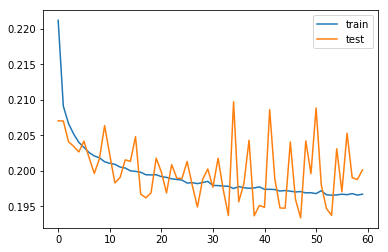

generated samples


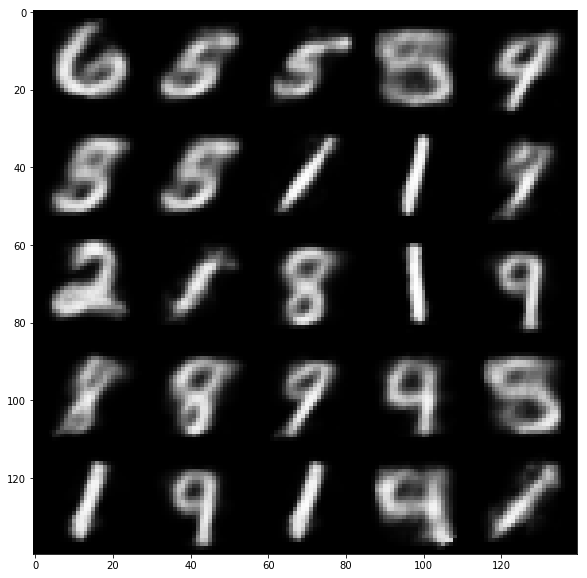

In [40]:
EPOCHS = 60

train_losses = []
test_losses = []

for epoch in range(1, EPOCHS+1):
    train_losses.append(train(train_dataset, epoch))
    test_losses.append(test(test_dataset, epoch))
    
    # generate new samples
    figure = np.zeros((28 * 5, 28 * 5))
    sample = Variable(t.randn(25, latent_dim))
    model.eval()
    sample = model.decode(sample).cpu()
    model.train()
    for k, s in enumerate(sample):
        i = k//5
        j = k%5
        digit = s.data.numpy().reshape(28, 28)
        figure[i * 28: (i + 1) * 28, j * 28: (j + 1) * 28] = digit
    
    print('epoch', epoch)
    print('losses')
    plt.plot(train_losses,label='train')
    plt.plot(test_losses,label='test')
    plt.legend()
    plt.show()
    print('generated samples')
    plt.figure(figsize=(10, 10))
    plt.imshow(figure, cmap='Greys_r')
    plt.show()
    display.clear_output(wait=True)


We observe that the decoded images are blurry. It may be due to the independence assumption of the pixel (each output pixel is independent of the others, which is a very simple approximation.) If there was a stronger dependency between the pixels, the predictions of the model would be much more accurate, because it would know that next to a black pixel probably lies another black pixel, which would make less blurry images

# Observing the latent space

This dataset being very simple, we used a 2D latent space. We can have a look at how images are encoded in that space. Hopefully, the model should learn something general about the image, so that digits should be clustered together

In [87]:
x,y = shuffle(train_dataset, train_labels)
x = variable(t.cat(x[:10000]))
y = t.cat(y[:10000]).numpy()

In [88]:
mu, logvar = model.encode(x)

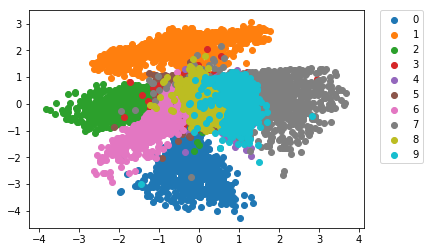

In [90]:
z = mu.data.numpy()
for i in range(0, 10):
    plt.scatter(z[y==i, 0], z[y==i, 1], label=str(i))
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.show()

As expected, the digits cluster together in the 2D space. 
It is interesting to see that digits that can be written similarly (for example, 1 and 7 or 9 and 8), share common frontiers in this space

# Conditional VAE
Generating random numbers is kind of interesting, but it does not give you any control over what you can generate. You may want to generate a specific numbers, or various versions of a same number. For make this possible, we can use a conditional VAE. The encoder and the decoders are passed with additional information, in this case the labels of the digits.

We use one-hot encoded labels

In [106]:
def one_hot(y):
    yy = np.zeros((y.shape[0], 10))
    yy[np.arange(y.shape[0]), y] = 1
    return yy

In [133]:
from torch.nn import Linear as fc, ReLU, Sigmoid, Dropout, BatchNorm1d as BN

relu = ReLU()
sigmoid = Sigmoid()

class CVAE(nn.Module):
    """
    The only difference is that now the encoder and the decoder have an additional input
    This input consists in an array of length 10, concatenated to the flattened picture in the encoder, and to the 
    latent code in the decoder
    """
    def __init__(self, latent_dim=2, hdim=400):
        super(CVAE, self).__init__()
        self.latent_dim = latent_dim
        self.hdim = hdim

        # encoder
        self.fc1 = fc(784+10, hdim)
        self.bn_1 = BN(hdim, momentum=.9)
        self.fc_mu = fc(hdim, latent_dim)  # output the mean of z
        self.bn_mu = BN(latent_dim, momentum=.9)
        self.fc_logvar = fc(hdim, latent_dim)  # output the variance of z
        self.bn_logvar = BN(latent_dim, momentum=.9)
        
        # decoder
        self.fc2 = fc(latent_dim+10, hdim)
        self.bn_2 = BN(hdim, momentum=.9)
        self.fc3 = fc(hdim, 784)
        self.bn_3 = BN(784, momentum=.9)

    def encode(self, x, y):
        h1 = relu(self.bn_1(self.fc1(t.cat([flatten(x), y], -1))))
        mu = self.bn_mu(self.fc_mu(h1))
        logvar = self.bn_logvar(self.fc_logvar(h1))
        return mu, logvar

    def reparameterize(self, mu, logvar):
        if self.training:
            std = t.exp(.5*logvar)
            eps = variable(np.random.normal(0, 1, (len(mu), self.latent_dim)))
            return mu + std*eps
        else:
            return mu

    def decode(self, z, y):
        h1 = relu(self.bn_2(self.fc2(t.cat([z,y], -1))))
        h2 = sigmoid(self.bn_3(self.fc3(h1)))
        batch_size = get_shape(h2)[0]
        x_dec = h2.resize(batch_size, 1, 28, 28)
        return x_dec

    def forward(self, x, y):
        mu, logvar = self.encode(x, y)
        z = self.reparameterize(mu, logvar)
        return self.decode(z, y), mu, logvar


In [134]:
model = CVAE()

In [135]:
optimizer = optim.RMSprop(model.parameters(), lr=1e-1)  # batch normalization allows to use a bigger than default learning rate

def train(train_dataset, train_labels, epoch, log=100):
    model.train()
    train_loss = 0
    train_dataset_, train_labels_ = shuffle(train_dataset, train_labels)
    for i in range(0, len(train_dataset), batch_size):
        batch_idx = i//batch_size
        
        # sample data
        x = variable(t.cat(train_dataset_[i:i+batch_size], 0))
        y = variable(one_hot(t.cat(train_labels_[i:i+batch_size]).numpy()))
        if len(x) != batch_size:
            continue
        
        # init grads
        optimizer.zero_grad()
        
        x_dec, mu, logvar = model(x, y)
        xent, kl = loss_function(x_dec, x, mu, logvar)
        loss = xent + kl
        
        # compute grads
        loss.backward()
        train_loss += loss.data[0]
        
        # update weights
        optimizer.step()

    print('====> Epoch: {} Average loss: {:.4f}'.format(
          epoch, train_loss * batch_size/len(train_dataset)))
    return train_loss*batch_size / len(train_dataset_)


def test(test_dataset, test_labels, epoch):
    model.eval()
    test_loss = 0
    test_dataset_, test_labels_ = shuffle(test_dataset, test_labels)
    for i in range(0, len(test_dataset), batch_size):
        batch_idx = i // batch_size
        
        # sample data
        x = variable(t.cat(test_dataset_[i:i+batch_size], 0))
        y = variable(one_hot(t.cat(test_labels_[i:i+batch_size]).numpy()))
        if len(x) != batch_size:
            continue
            
        x_dec, mu, logvar = model(x,y)
        xent, kl = loss_function(x_dec, x, mu, logvar)
        test_loss += (xent+kl).data.numpy()[0]
            
    test_loss /= (len(test_dataset)/batch_size)
    print('====> Test set loss: {:.4f}'.format(test_loss))
    
    return test_loss




====> Epoch: 60 Average loss: 0.1709
====> Test set loss: 0.1682
epoch 60
losses


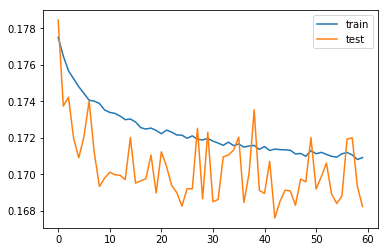

generated samples


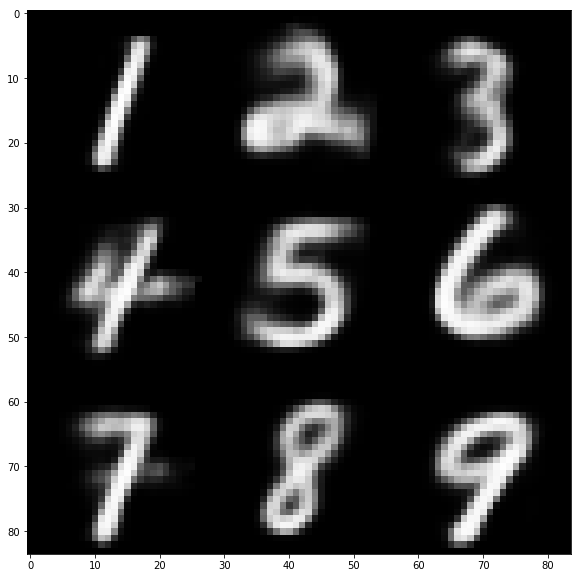

In [141]:
EPOCHS = 60

train_losses = []
test_losses = []

for epoch in range(1, EPOCHS+1):
    train_losses.append(train(train_dataset, train_labels, epoch))
    test_losses.append(test(test_dataset, test_labels, epoch))
    
    # generate new samples
    figure = np.zeros((28 * 3, 28 * 3))
    sample = variable(t.randn(9, latent_dim))
    digits = variable(one_hot(np.arange(1, 10, 1)))
    model.eval()
    sample = model.decode(sample, digits).cpu()
    model.train()
    for k, s in enumerate(sample):
        i = k//3
        j = k%3
        digit = s.data.numpy().reshape(28, 28)
        figure[i * 28: (i + 1) * 28, j * 28: (j + 1) * 28] = digit
    
    print('epoch', epoch)
    print('losses')
    plt.plot(train_losses,label='train')
    plt.plot(test_losses,label='test')
    plt.legend()
    plt.show()
    print('generated samples')
    plt.figure(figsize=(10, 10))
    plt.imshow(figure, cmap='Greys_r')
    plt.show()
    display.clear_output(wait=True)


We notice that now, the latent space is no longer used to encode the actual digits, but rather the shape or the style of the digit. All the information about what the image contains (the label) is contained in the additional input. This way, it is possible to sample different version of a single digit.

Notice that the images tend to be less blurry than with vanilla VAE. It is due to the fact that the inputs contain strictly more information about the picture that should be decoded. As a consequence, the decoder has more certainty about the pixels, since digits, even though the can differ in styles, tend to have similar pixel values

Let's generate a few different 9s

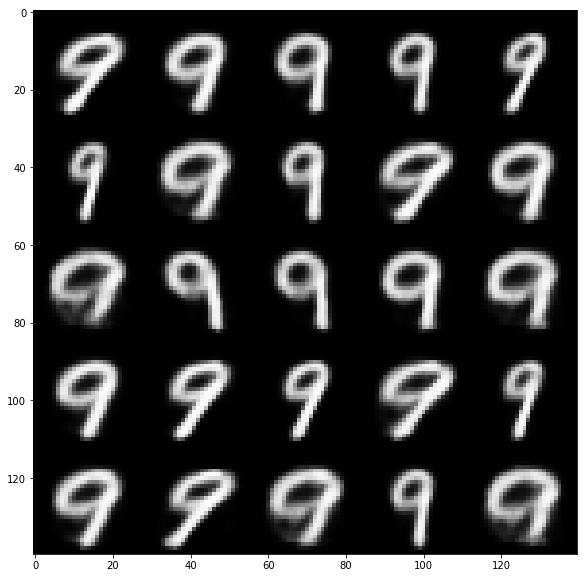

In [148]:
# generate new samples
n = 5
digit = 9

figure = np.zeros((28 * n, 28 * n))
sample = variable(t.randn(n*n, latent_dim))
digits = variable(one_hot(np.array(n*n*[digit])))
model.eval()
sample = model.decode(sample, digits).cpu()
model.train()
for k, s in enumerate(sample):
    i = k//n
    j = k%n
    digit = s.data.numpy().reshape(28, 28)
    figure[i * 28: (i + 1) * 28, j * 28: (j + 1) * 28] = digit
plt.figure(figsize=(10, 10))
plt.imshow(figure, cmap='Greys_r')
plt.show()